# Прогнозирование уровня средней заработной платы в России

In [6]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from scipy import stats
import statsmodels.api as sm
from itertools import product
import warnings
from tqdm import tqdm
from datetime import datetime 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns; sns.set()

# Загрузка данных

Данные о среднемесячных уровнях заработной платы в России:

In [7]:
wage = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'],
                   parse_dates=['month'], dayfirst=True)

Посмотрим на первые 5 строк

In [8]:
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


---

# Построение прогнозов

## Визуальный анализ ряда

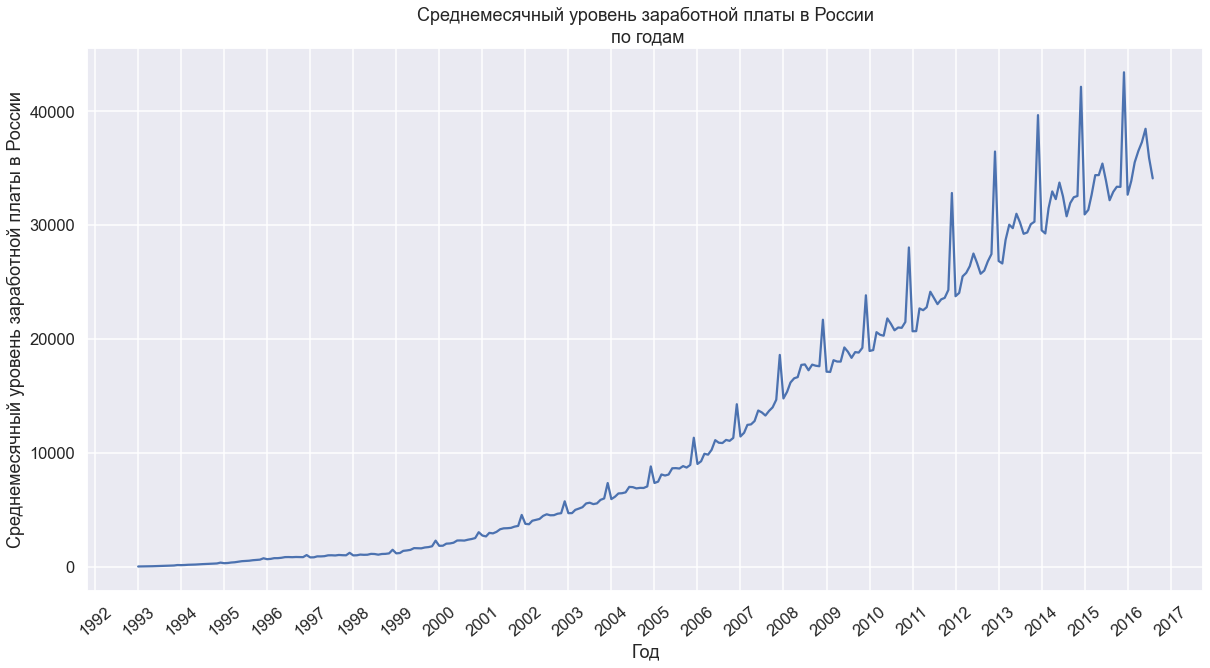

In [10]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=wage.index, y=wage.WAG_C_M, ax=ax)
ax.set(xlabel="Год",
       ylabel="Cреднемесячный уровень заработной платы в России",
       title="Cреднемесячный уровень заработной платы в России\n по годам")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.xticks(rotation=40);

__Особенности данного ряда:__

- Сильно выраженная годовая сезонность: максимум приходится на _декабрь_ , а минимум приходится на _январь_
- Нелинейный возрастающий тренд
- Выраженная гетероскедастичность: дисперсия со временем увеличивается

### Проверка стационарности и STL-декомпозиция ряда:

Проверим следующую гипотезу с помощью статистического критерия Дики-Фуллера:

$H_0\colon ряд \;нестационарен$

$H_1\colon ряд \;стационарен$

In [11]:
p_value = sm.tsa.stattools.adfuller(wage.WAG_C_M)[1]
print("Критерий Дики-Фуллера: p=%f" % p_value)

Критерий Дики-Фуллера: p=0.991850


Уровень значимости получился $p\gg 0.05$, что вполне ожидаемо следует из графика.

Разложим ряд на составляющие, причем, укажем `model='multiplicative'`, так как четко видно увеличение амплитуды с ростом значения по тренду

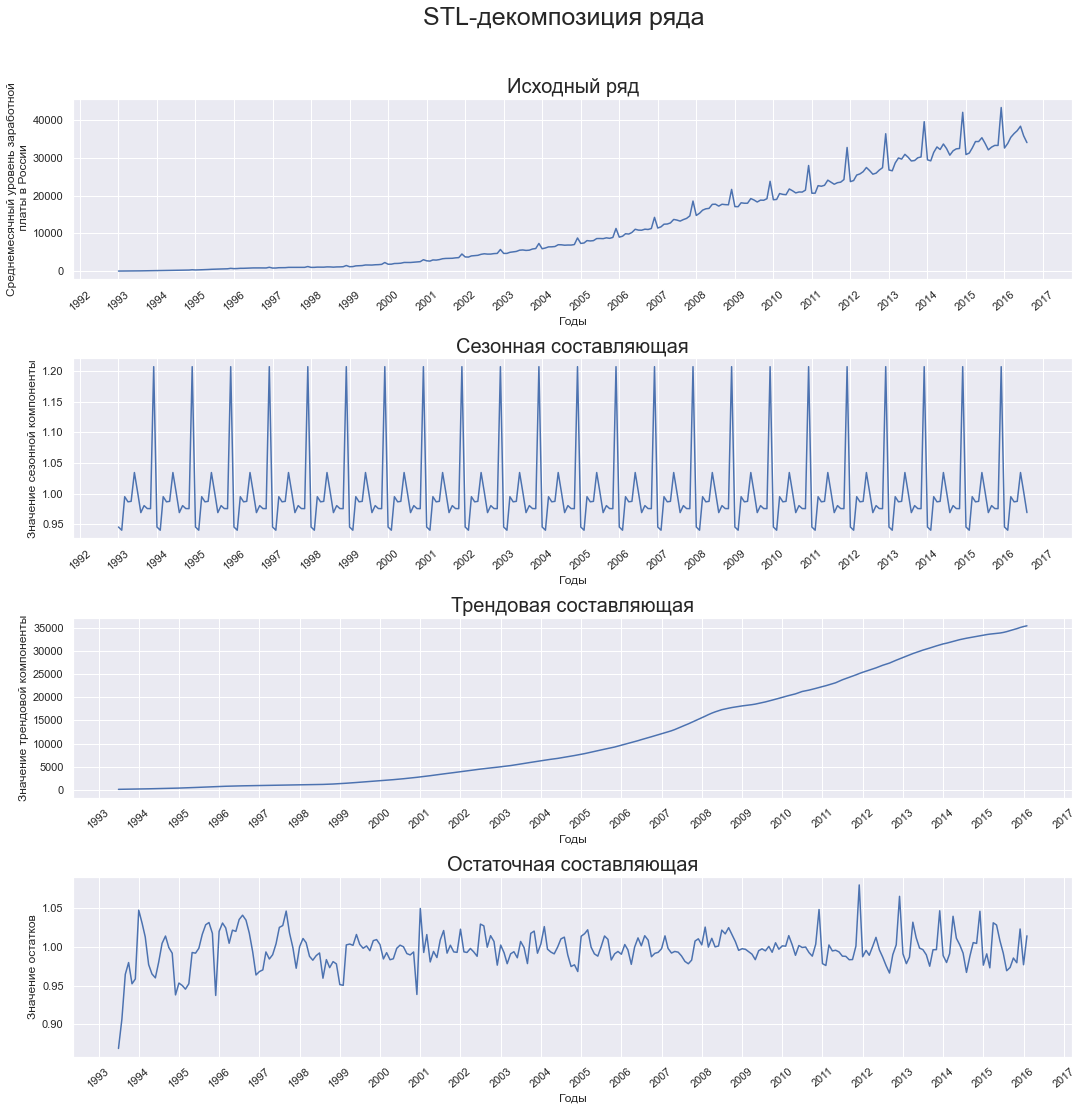

In [12]:
sns.set_context('notebook')
res = sm.tsa.seasonal_decompose(wage.WAG_C_M, model='multiplicative')
fig, axs = plt.subplots(4, 1, figsize=(16, 16)) 
fig.tight_layout(pad=5)
fig.suptitle('STL-декомпозиция ряда', fontsize=25)
plt.subplots_adjust(top=0.9, wspace=20)

y_labels = ['Cреднемесячный уровень заработной\n платы в России',
            'Значение сезонной компоненты', 
            'Значение трендовой компоненты', 
            'Значение остатков']
names = ['Исходный ряд', 'Сезонная составляющая', 
         'Трендовая составляющая', 'Остаточная составляющая']
for i, data, name, y_label in zip([0, 1, 2, 3],
                                  [res.observed, res.seasonal, 
                                   res.trend, res.resid], names, y_labels):
    sns.lineplot(x=wage.index, y=data, ax=axs[i]).set_title(name, fontsize=20)
    axs[i].xaxis.set_major_locator(mdates.YearLocator())
    axs[i].xaxis.set_major_formatter(DateFormatter("%Y"))
    axs[i].tick_params(axis='x', labelrotation=40)
    axs[i].set_xlabel('Годы')
    axs[i].set_ylabel(y_label)

__Выводы по STL:__
1. Тренд действительно повышается со временем, причем, иногда быстрее, а иногда медленнее. 
2. Сезонность сильно выраженна,  динамика стабильна и почти не изменяется.
3. Остатки, скорее всего, распределены нормально, но на графике видны небольшие выбросы.

Проанализируем распределение остатков

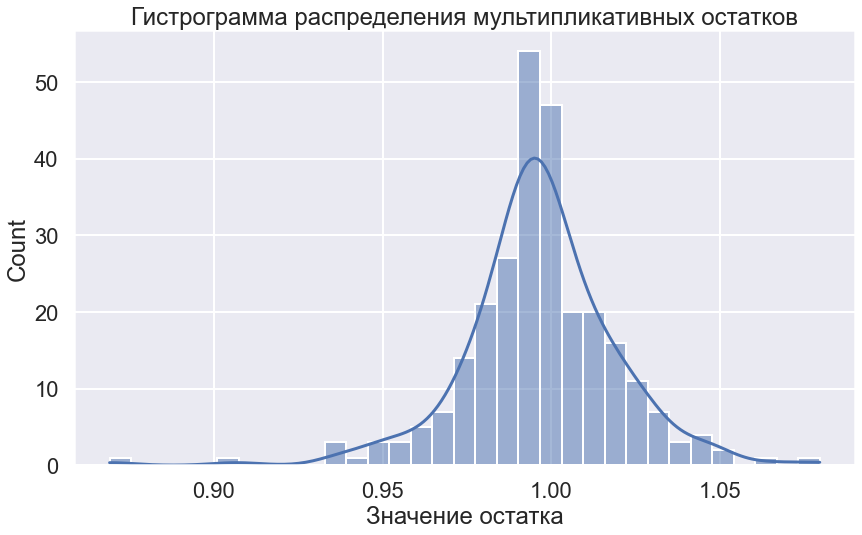

In [21]:
sns.set_context('poster')
plt.figure(figsize=(14, 8))
sns.histplot(res.resid.dropna(), kde=True)
plt.title('Гистрограмма распределения мультипликативных остатков')
plt.xlabel('Значение остатка');

Распределене действительно похоже на нормальное с математическим ожиданием $<1$, проверим нормальность распределения с помощью теста Шапиро-Уилка:

In [22]:
print('Значение p-value:', stats.shapiro(res.resid.dropna())[1])

Значение p-value: 5.872913710902594e-09


Достигаемый уровень значимости получился очень маленьким, а это значит, что распределение остатков, скорее всего, не нормальное. Это связано с тем, что некоторые остатки являются выбросами. Несмотря на это распределение остатков выглядит симметричным.

## Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

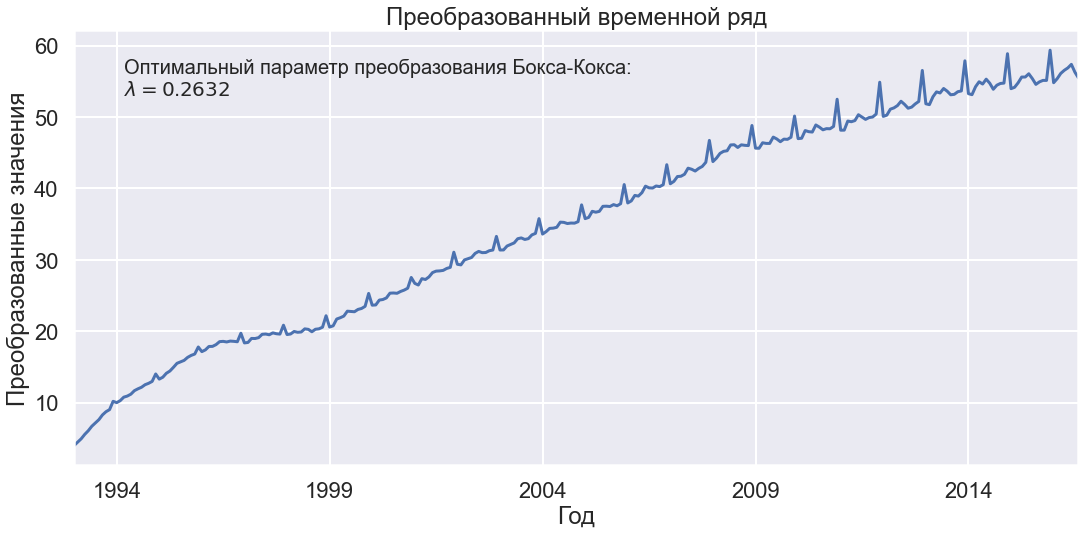

In [23]:
wage['WAG_C_M_box'], lmbda = stats.boxcox(wage.WAG_C_M)
fig, ax = plt.subplots(figsize=(18, 8))
wage.WAG_C_M_box.plot(ax=ax)
plt.text(0.05, 0.85, 
         'Оптимальный параметр преобразования Бокса-Кокса:\n$\lambda={:.4f}$'\
         .format(lmbda), fontsize=20, transform=ax.transAxes);
ax.set(xlabel=u'Год',
       ylabel=u'Преобразованные значения',
       title=u'Преобразованный временной ряд');

Проверим следующую гипотезу с помощью статистического критерия Дики-Фуллера после преобразования Бокса-Кокса:

$H_0\colon ряд \;нестационарен$

$H_1\colon ряд \;стационарен$

In [24]:
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(wage.WAG_C_M_box)[1]}')

Критерий Дики-Фуллера: p=0.6968987634832758


Уровень значимости стал меньше, однако он еще достаточно велик, чтобы утверждать, что ряд стационарный. Действительно, ряд сохранил свойство тренда и сезонности.

## Выбор порядка дифференцирования

Для того чтобы избавиться от тренда и сезонности, необходимо продифференцировать ряд. Первым делом попробуем сезонное дифференцирование.

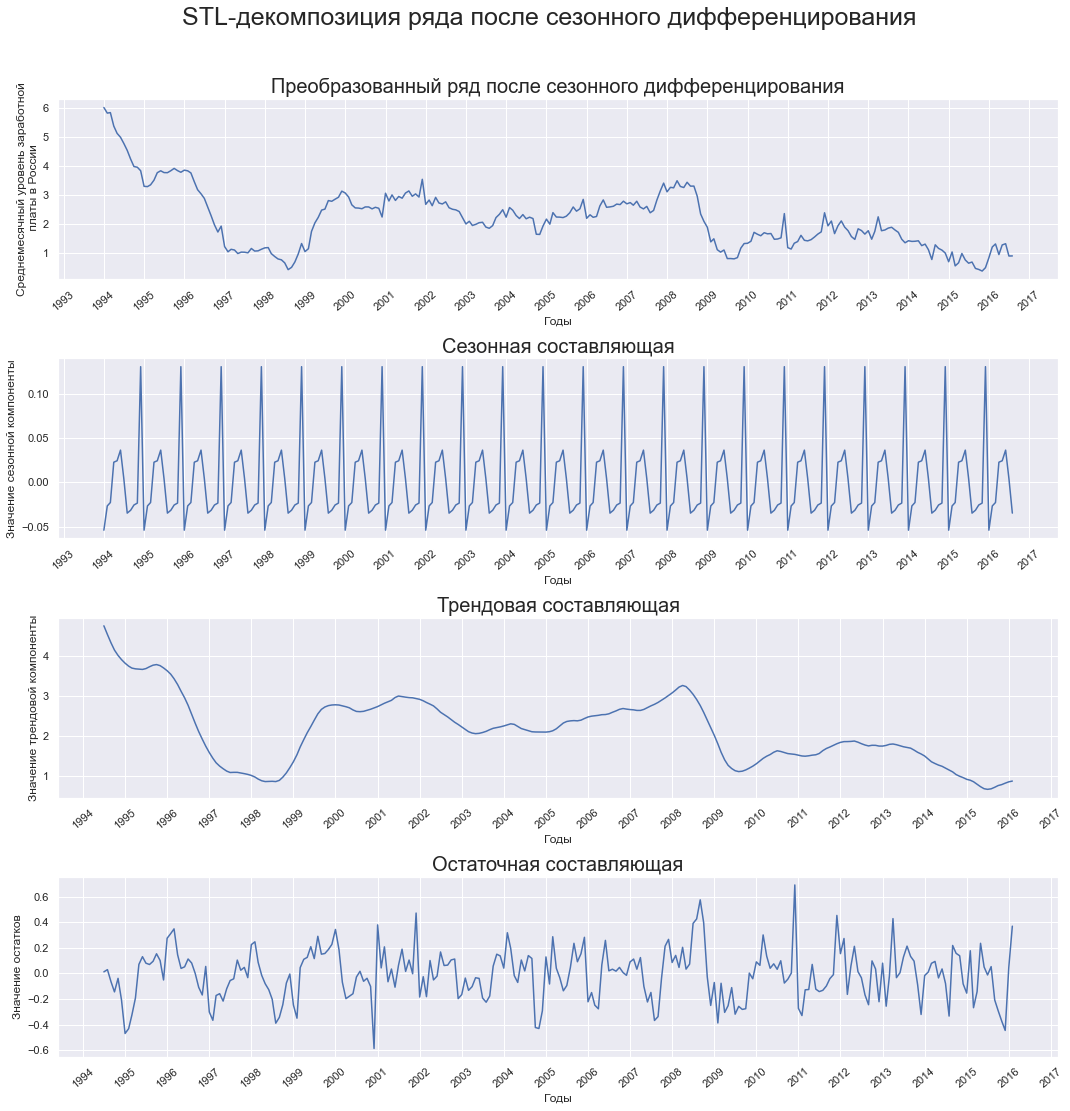

In [25]:
wage['WAG_C_M_box_seasonal_diff'] = wage.WAG_C_M_box - wage.WAG_C_M_box.shift(12)
res_sd = sm.tsa.seasonal_decompose(wage.WAG_C_M_box_seasonal_diff[12:])

sns.set_context('notebook')
fig, axs = plt.subplots(4, 1, figsize=(16, 16)) 
fig.tight_layout(pad=5)
fig.suptitle('STL-декомпозиция ряда после сезонного дифференцирования', 
             fontsize=25)
plt.subplots_adjust(top=0.9, wspace=20)
names[0] = 'Преобразованный ряд после сезонного дифференцирования'
for i, data, name, y_label in zip([0, 1, 2, 3], 
                                  [res_sd.observed, res_sd.seasonal, 
                                   res_sd.trend, res_sd.resid], 
                                  names, y_labels):
    sns.lineplot(x=wage.index[12:],y=data, ax=axs[i]).set_title(name, 
                                                                fontsize=20)
    axs[i].xaxis.set_major_locator(mdates.YearLocator())
    axs[i].xaxis.set_major_formatter(DateFormatter("%Y"))
    axs[i].tick_params(axis='x', labelrotation=40)
    axs[i].set_xlabel('Годы')
    axs[i].set_ylabel(y_label)

Ряд больше стал похож на стационарный, однако, трендовая компонента еще осталась. Проверим уровень значимости критерия Дики-Фуллера после сезонного дифференцирования преобразованного ряда.

In [26]:
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(wage.WAG_C_M_box_seasonal_diff[12:])[1]}')

Критерий Дики-Фуллера: p=0.014697133494791808


Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

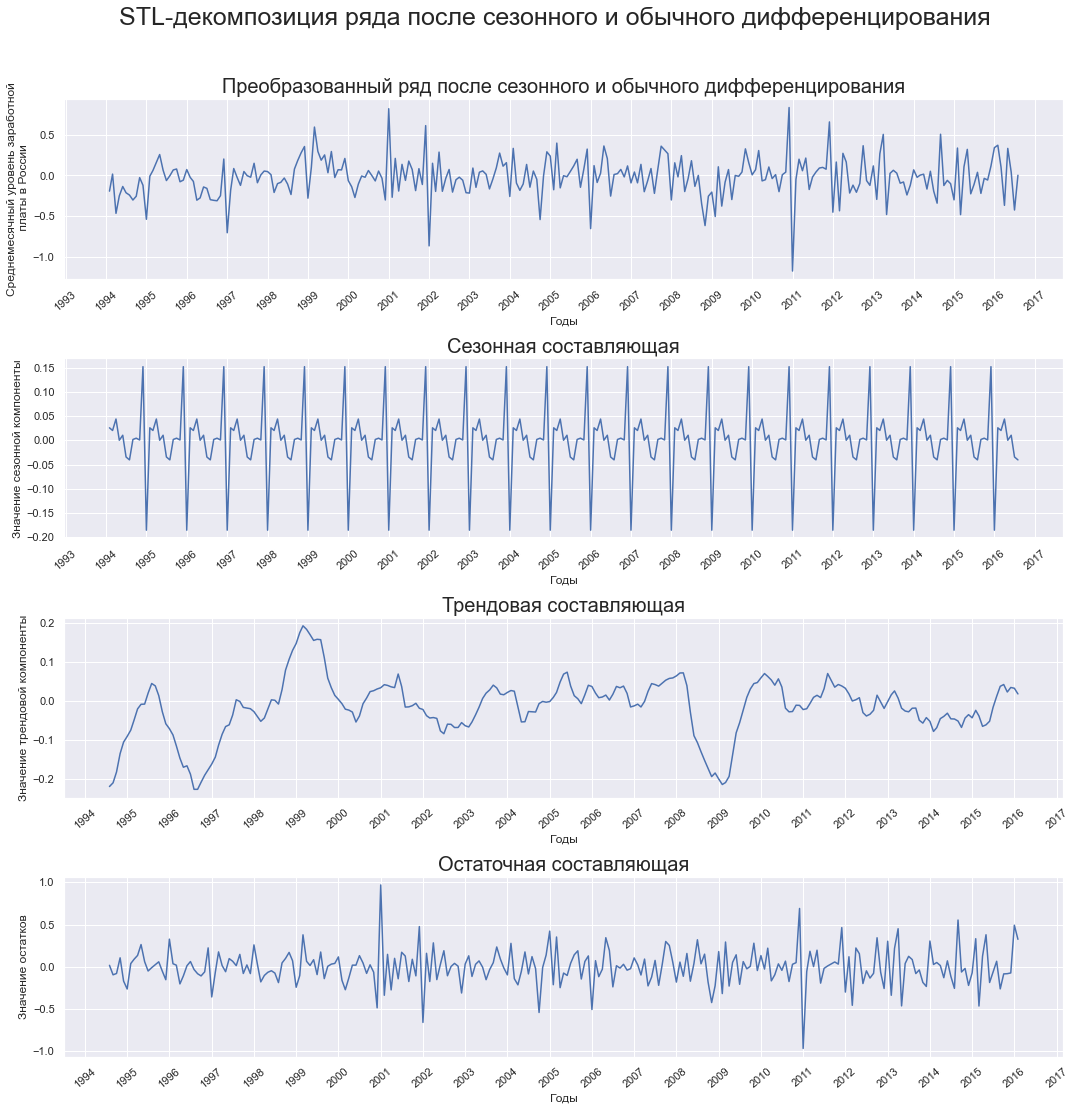

In [27]:
wage['WAG_C_M_box_double_diff'] = wage.WAG_C_M_box_seasonal_diff - wage.WAG_C_M_box_seasonal_diff.shift(1)
res_dd = sm.tsa.seasonal_decompose(wage.WAG_C_M_box_double_diff[13:])

fig, axs = plt.subplots(4, 1, figsize=(16, 16)) 
fig.tight_layout(pad=5)
fig.suptitle('STL-декомпозиция ряда после сезонного и обычного дифференцирования', 
             fontsize=25)
plt.subplots_adjust(top=0.9, wspace=20)
names[0] = 'Преобразованный ряд после сезонного и обычного дифференцирования'
for i, data, name, y_label in zip([0, 1, 2, 3], 
                                  [res_dd.observed, res_dd.seasonal, 
                                   res_dd.trend, res_dd.resid], 
                                  names, y_labels):
    sns.lineplot(x=wage.index[13:],y=data, ax=axs[i]).set_title(name, 
                                                                fontsize=20)
    axs[i].xaxis.set_major_locator(mdates.YearLocator())
    axs[i].xaxis.set_major_formatter(DateFormatter("%Y"))
    axs[i].tick_params(axis='x', labelrotation=40)
    axs[i].set_xlabel('Годы')
    axs[i].set_ylabel(y_label)

Визуально ряд выглядит лучше — от тренда получилось почти полностью избавиться.  Проверим уровень значимости критерия Дики-Фуллера после сезонного и обычного дифференцирования преобразованного ряда.

In [29]:
print(f'Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(wage.WAG_C_M_box_double_diff[13:])[1]}')

Критерий Дики-Фуллера: p = 5.2036037158213736e-08


Гипотеза нестационарности отвергается. Уровень значимости получился ничтожно мал.

## Выбор начальных приближений для $\textbf{p, q, P, Q}$

Для подбора оптимальных начальных приближений для $p, q, P, Q$ необходимо проанализировать __ACF__ _(Autocorrelation function)_ и __PACF__ _(Partial autocorrelation function)_

Согласно некоторым эвристикам количество лагов на данных графиках следует выбрать как: 


$$\tau \leq \frac{N}{4},$$ 
где 
- $N$ - количество данных
- $\tau$ - количество лагов

In [30]:
num_of_lags = wage.WAG_C_M_box_double_diff[13:].shape[0]//4

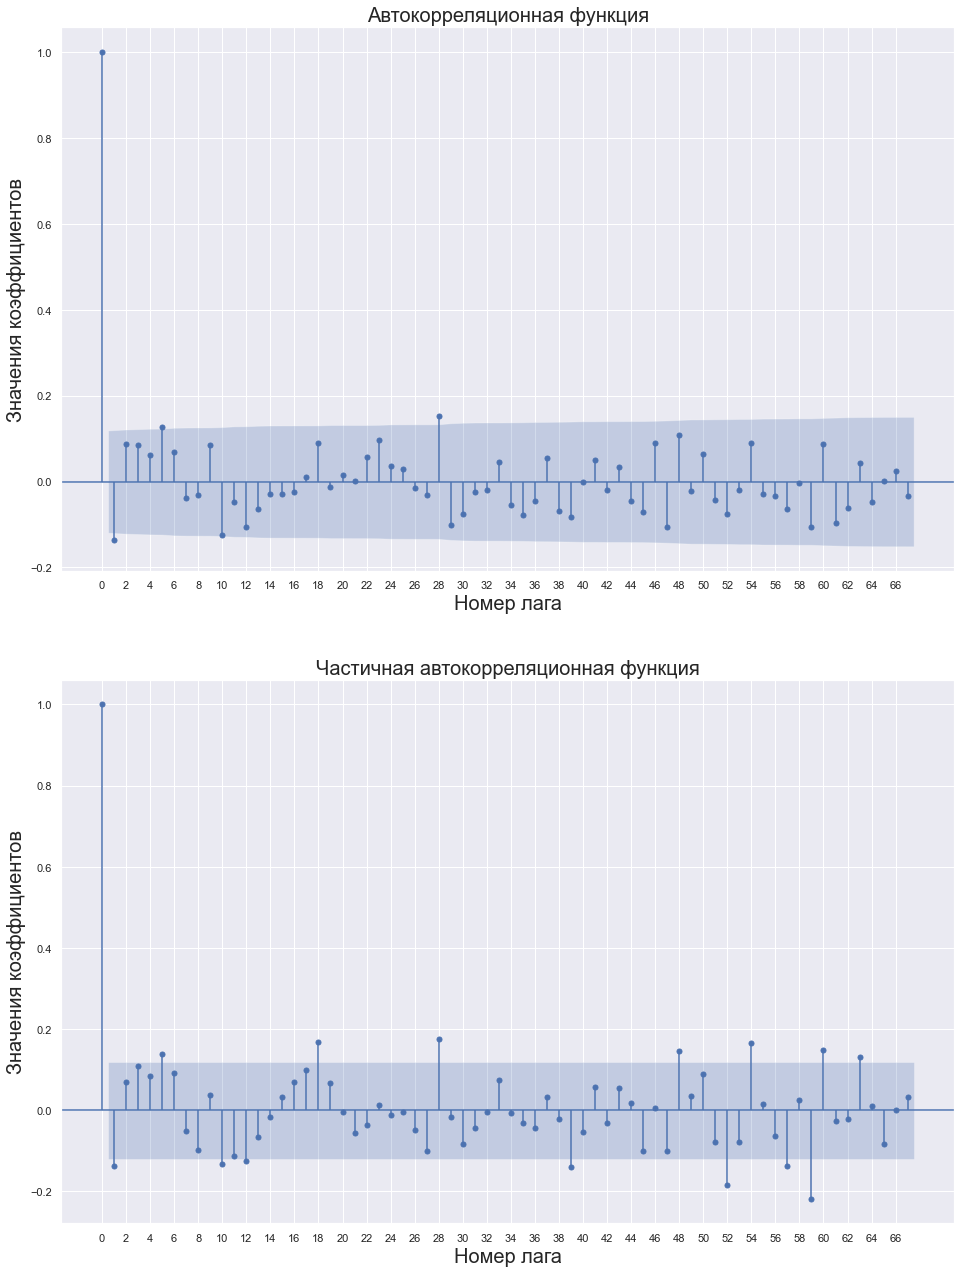

In [31]:
fig, axs = plt.subplots(2,1, figsize=(16, 22))
sns.set_context('notebook')
plt.subplots_adjust(hspace=0.2)
sm.graphics.tsa.plot_acf(wage.WAG_C_M_box_double_diff[13:].values.squeeze(),
                         ax=axs[0],
                         title='Автокорреляционная функция', lags=num_of_lags)
sm.graphics.tsa.plot_pacf(wage.WAG_C_M_box_double_diff[13:].values.squeeze(), 
                          ax=axs[1], 
                          title='Частичная автокорреляционная функция', 
                          lags=num_of_lags)
titles = ['Автокорреляционная функция', 'Частичная автокорреляционная функция']
for i in [0,1]:
    axs[i].set_xticks(np.arange(0, num_of_lags, 2))
    axs[i].set_xlabel('Номер лага', fontsize=20)
    axs[i].set_ylabel('Значения коэффициентов', fontsize=20)
    axs[i].set_title(titles[i], fontsize=20)
plt.show()

Сезонный период равен $S=12$.

Начальное приближение для $Q$ - последний значимый сезонный лаг на графике автокорреляционной функции. Значимых сезонных лагов нет, следоватеьлно, $Q=0$.

Начальное приближение для $q$ - последний значимый несезонный лаг на графике автокорреляционной функции. В данном случае это 5-й лаг, т.е. $q=5$. При этом необходимо уточнить, что $q$ не может быть больше $S$, т.е. $q < S$. 

Начальное приближение для $P$ - последний значимый сезонный лаг на графике частичной автокорреляционной функции. Максимальный значимый лаг, кратный $S=12$ - это $ 60 = 12 * 5$, т.е. $P = 5$.

Начальное приближение для $p$ - последний значимый несезонный лаг на графике частичной автокорреляционной функции. Это 10-й лаг, т.е. $p=10$. Аналогично $p < S=12$.

__Итого:__

- $Q = 0$
- $q = 5$
- $P = 5$
- $p = 10$

## Обучение и сравнение моделей-кандидатов, выбор победителя

Переберем все значения начальных приближений от 0 до подобранных значений. Для $Q$ я также добавлю три возможных варианта $\{0, 1, 2\}$

In [32]:
Qs = range(0, 2)
qs = range(0, 5)
Ps = range(0, 5)
ps = range(0, 10)
D=1
d=1

Составим список из всех комбинаций значений параметров.

In [33]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Количество моделей:', len(parameters_list))

Количество моделей: 500


In [21]:
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(wage.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 500/500 [1:24:21<00:00, 10.12s/it]


Посмотрим Топ-10 моделей по критерию __Акаике__:

$$AIC = -2 lnL + 2k,$$
где 

- $L - $ правдоподобие
- $k = P + Q + p + q + 1 - $ число параметров модели

In [39]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
sorted_result_table = result_table.sort_values(by = 'aic', ascending=True)
print(sorted_result_table.head(10))

       parameters        aic
399  (7, 4, 4, 1) -28.884932
129  (2, 2, 4, 1) -27.799596
139  (2, 3, 4, 1) -26.726479
341  (6, 4, 0, 1) -25.027661
342  (6, 4, 1, 0) -24.816151
149  (2, 4, 4, 1) -23.859967
279  (5, 2, 4, 1) -23.540707
189  (3, 3, 4, 1) -23.459037
339  (6, 3, 4, 1) -23.327200
391  (7, 4, 0, 1) -23.299641


In [45]:
print('Значение параметров лучшей модели:\np={}\nq={}\nP={}\nQ={}\nЗначение критерия AIC={:.4f}'\
      .format(*sorted_result_table.iloc[0, :][0], sorted_result_table.iloc[0, :][1]))

Значение параметров лучшей модели:
p=7
q=4
P=4
Q=1
Значение критерия AIC=-28.8849


Значение критерия AIC получилось отрицательным, что вполне возможно, так как это относительная мера качества. Данный критерий интерпритируется только при сравнении нескольких моделей.

Посмотрим на подробную характеристику лучшей модели.

In [49]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(7, 1, 4)x(4, 1, [1], 12)   Log Likelihood                  31.442
Date:                              Tue, 04 Aug 2020   AIC                            -28.885
Time:                                      17:42:14   BIC                             32.351
Sample:                                  01-01-1993   HQIC                            -4.298
                                       - 08-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7597      0.082      9.299      0.000       0.600       0.920
ar.L2         -0.36

__Модель:__
- `No. Observations` - количество наблюдаемых данных
- `Log Likelihood` - значение $lnL$
- `AIC` - значение критерия Акаике
- `BIC` _[Байесовский информационный критерий](https://ru.wikipedia.org/wiki/Информационный_критерий#Байесовский_информационный_критерий_(BIC)_или_критерий_Шварца_(SC))_${\displaystyle BIC=k\ln n-2\ln L}$ (n - объем выборки)
- `HQIC` _[Критерий Ханнана-Куинна](https://ru.wikipedia.org/wiki/Информационный_критерий#Байесовский_информационный_критерий_(BIC)_или_критерий_Шварца_(SC))_ ${\displaystyle HQ=\frac{2k\ln \ln n}{n}-\frac{2\ln n}{n}}$
- `cov_type` - метод расчета ковариационной матрицы оценок параметров (`opg` - outer product of gradient estimator)


__Признаки:__
- `coef` - значение коэффициента при том или ином признаке (показывает важность признака)
- `P>|z|` - значимость веса каждого признака

__Остатки:__
- Тест `Ljung-Box` _[Q-тест Льюнг — Бокса](https://ru.wikipedia.org/wiki/Q-тест_Льюнг_—_Бокса)_ дает уровень значимости равный 0.91, что означает, что нулевую гипотезу о случайности остатков опровергнуть нельзя.
- Тест `Heteroskedasticity` _(Тест на гетероскедастичность стандартизированных остатков)_ дает маленький уровеь значимости, что означает, что гетероскедастичности в остатках нет.
- Тест `Jarque-Bera` _[Тест Харке — Бера](https://ru.wikipedia.org/wiki/Тест_Харке_—_Бера)_ дает очень маленький уровень значимоси, значит можно утверждать, что остатки распределены нормально. 
- `Skew` _[Коэффициент асимметрии](https://ru.wikipedia.org/wiki/Коэффициент_асимметрии)_ равен 0.41 (умеренная ассиметрия) 
- `Kurtosis` _[Коэффициент эксцесса](https://ru.wikipedia.org/wiki/Коэффициент_эксцесса)_ равен 5.11 (эмпирическое распределение является более крутым относительно нормального)

## Анализ остатков

Text(0.5, 1.0, 'Автокорреляционная функция')

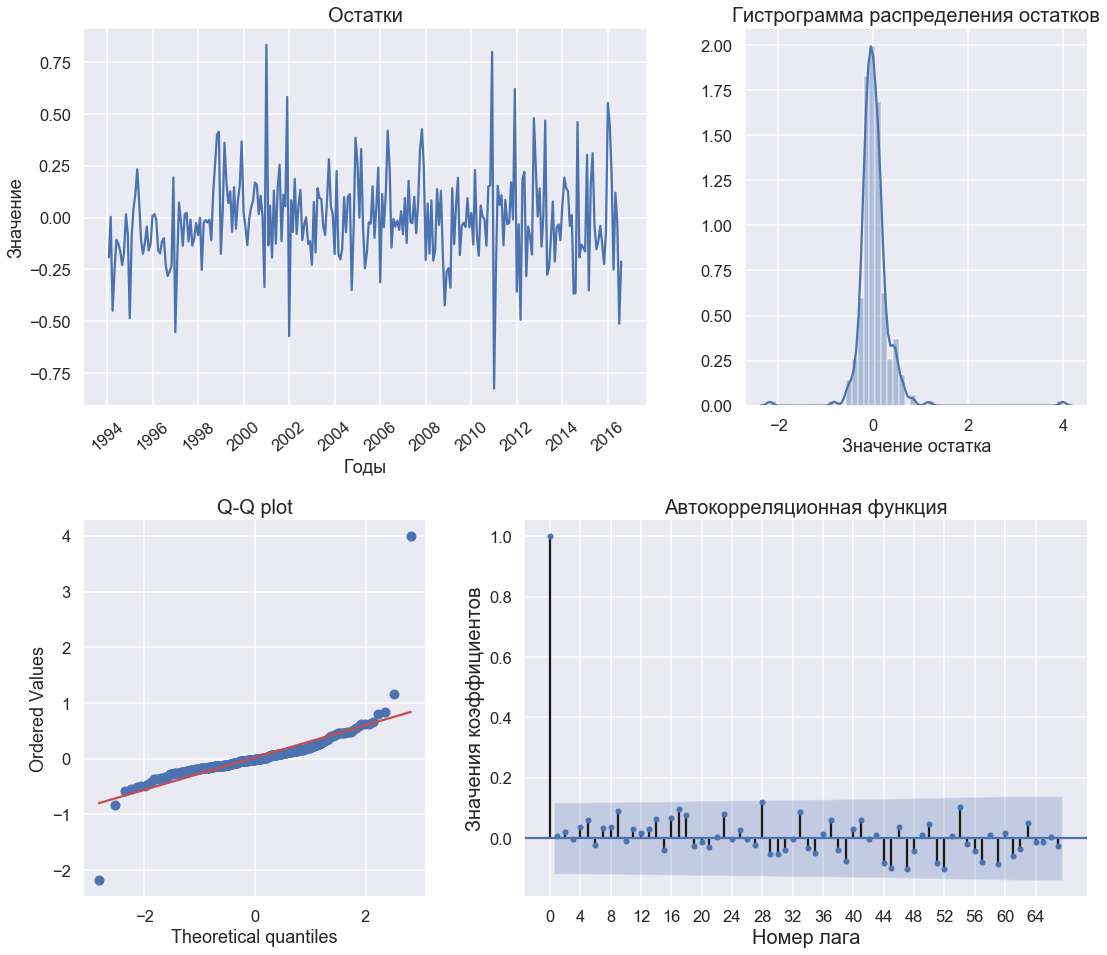

In [111]:
plt.figure(figsize=(18, 16))
grid = plt.GridSpec(2, 5, wspace=0.8, hspace=0.3)
ax = plt.subplot(grid[0, :3])
sns.lineplot(x=wage.index[13:],
             y=best_model.resid[13:]).set_title('Остатки', fontsize=20)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.tick_params(axis='x', labelrotation=40)
ax.set_xlabel('Годы')
ax.set_ylabel('Значение')

ax = plt.subplot(grid[0, 3:])
sns.distplot(best_model.resid.dropna()).set_title('Гистрограмма распределения остатков', fontsize=20)
ax.set_xlabel('Значение остатка')
ax = plt.subplot(grid[1, :2])
stats.probplot(best_model.resid.dropna(), dist="norm", plot=plt)
ax.set_title('Q-Q plot', fontsize=20)
ax = plt.subplot(grid[1, 2:])
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), 
                         ax=ax, lags=num_of_lags)
ax.set_xticks(np.arange(0, num_of_lags, 4))
ax.set_xlabel('Номер лага', fontsize=20)
ax.set_ylabel('Значения коэффициентов', fontsize=20)
ax.set_title('Автокорреляционная функция', fontsize=20)

In [117]:
print("Критерий Стьюдента: p={:.4f}".format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print("Критерий Дики-Фуллера: p={:.4f}".format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

Критерий Стьюдента: p=0.4702
Критерий Дики-Фуллера: p=0.0000


__Выводы по графикам:__

- Остатки _несмещены_ (подтверждается критерием Стьюдента)
- Остатки _стационарны_ (подтверждается критерием Дики-Фуллера и визуально)
- Остатки _неавтокоррелированы_ (подтверждается критерием Льюнга-Бокса и коррелограммой)
- Остатки _распределены нормально_ (подтверждается тестом Харке—Бера, гистограммой и Q-Q Plot графиком)
- Остатки _не гетероскедастичны_ (подтверждается тестом на гетероскедастичность стандартизированных остатков и визуально)

Модель получилась достаточно хорошей, посмотрим, как она описывает исходный ряд. Для этого создадим функцию, которая делает обратное преобразование Бокса-Кокса.

In [118]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

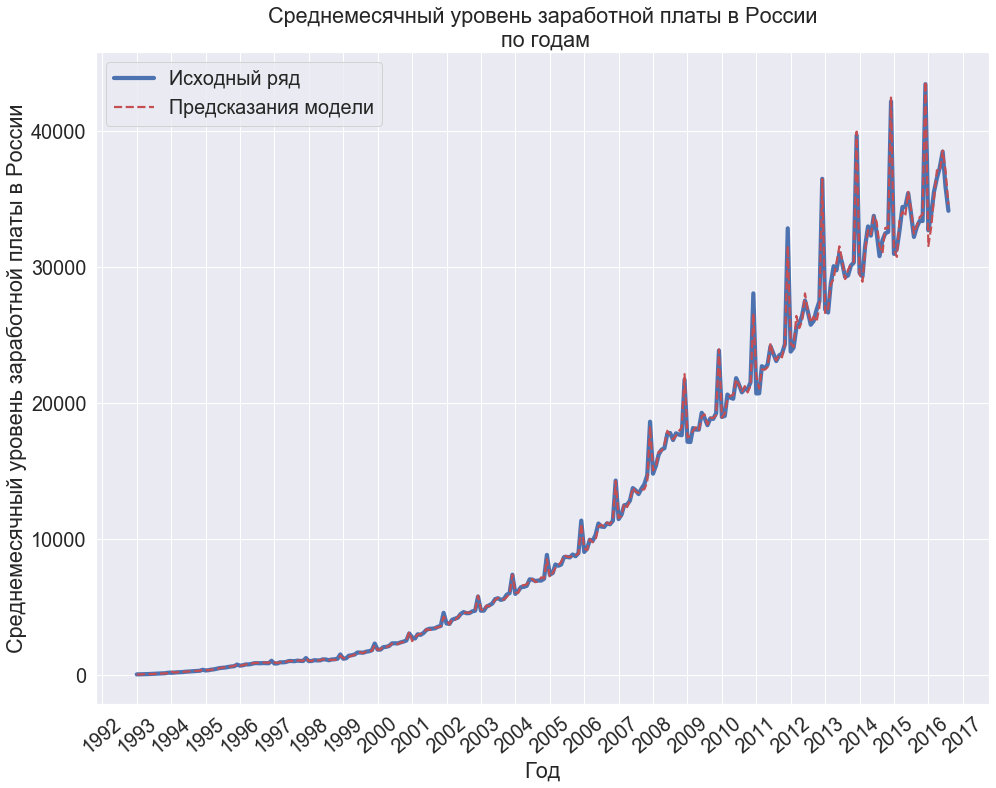

In [196]:
sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 4.2})

wage['model'] = invboxcox(best_model.fittedvalues, lmbda)

fig, ax = plt.subplots(figsize=(16, 12))
sns.lineplot(x=wage.index, y=wage.WAG_C_M, ax=ax)
sns.lineplot(x=wage.index, y=wage.model, ax=ax, color='r')
plt.setp(ax.lines[1], linewidth=2.2)
ax.lines[1].set_linestyle("--")
ax.legend(['Исходный ряд', 'Предсказания модели'])
ax.set(xlabel="Год",
       ylabel="Cреднемесячный уровень заработной платы в России",
       title="Cреднемесячный уровень заработной платы в России\n по годам")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.xticks(rotation=40);

Модель отлично описывает исходный ряд.

## Прогнозирование с помощью финальной модели

Построим прогноз на каждый месяц на два года вперёд от конца данных с помощью лучшей модели.

In [299]:
def add_one_month(date):
    if date.month + 1 > 12:
        return datetime(date.year + 1, 1, date.day)
    else:
        return datetime(date.year, date.month + 1, date.day)

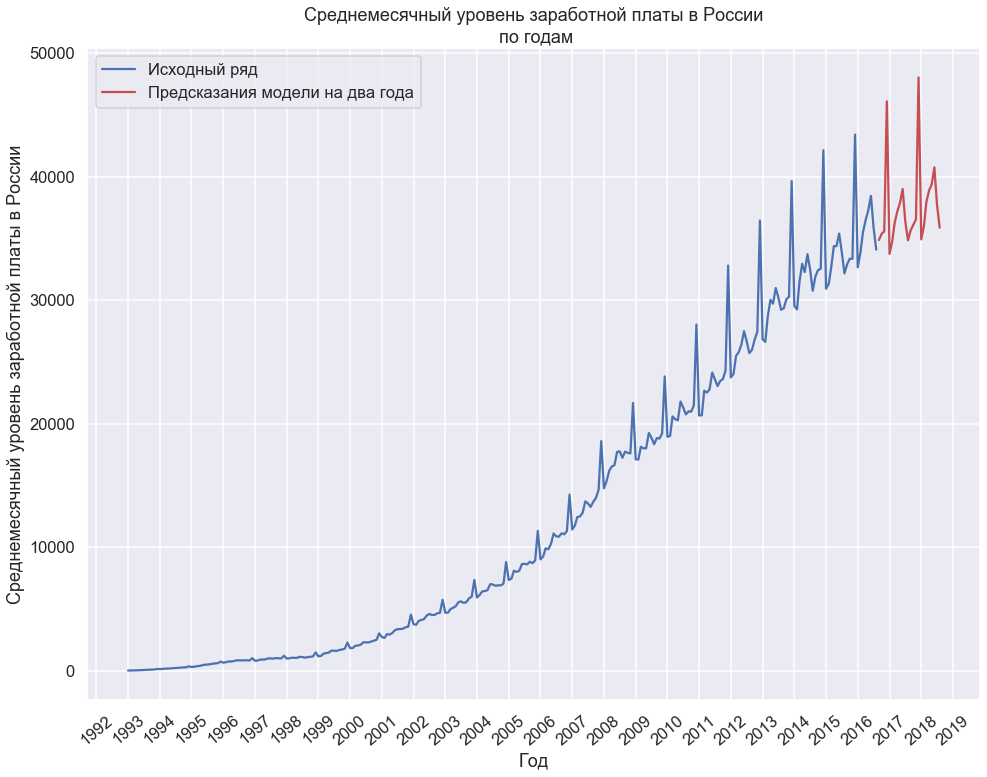

In [365]:
wage_forecast = wage[['WAG_C_M']]
last_date = datetime.utcfromtimestamp(wage_forecast.iloc[[-1]].index.values[0].tolist()/1e9)
date_list = [datetime.strptime(add_one_month(last_date)\
                               .strftime("%Y-%m-%d"), "%Y-%m-%d") +\
             relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(index=date_list, columns= wage_forecast.columns)
wage_forecast = pd.concat([wage_forecast, future])
wage_forecast['forecast'] = invboxcox(best_model.predict(start=wage.shape[0],
                                                         end=wage_forecast.shape[0]),
                                      lmbda)

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 12))

sns.lineplot(x=wage.index, y=wage.WAG_C_M, ax=ax)
sns.lineplot(x=wage_forecast.index, y=wage_forecast.forecast, ax=ax, color='r')
ax.set(xlabel="Год",
       ylabel="Cреднемесячный уровень заработной платы в России",
       title="Cреднемесячный уровень заработной платы в России\n по годам")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.xticks(rotation=40)
ax.legend(['Исходный ряд', 'Предсказания модели на два года']);

Прогноз на 2 года вперед выглядит достаточно адекватно. Тренд и сезонность сохраняется. Проверим, действительно ли модель хорошо прогназирует данные. Для этого возьмем [актуальный данные](http://sophist.hse.ru/hse/1/tables/WAG_M.htm) на 3 года вперед после крайней даты изначальных данных.

In [366]:
wage_curr = pd.read_csv('WAG_C_M_curr.csv', ';', index_col=['month'], 
                        parse_dates=['month'], dayfirst=True)
wage_curr.head()

,WAG_C_M
month,
2016-09-01,35843
2016-10-01,35749
2016-11-01,36195
2016-12-01,47554
2017-01-01,34422


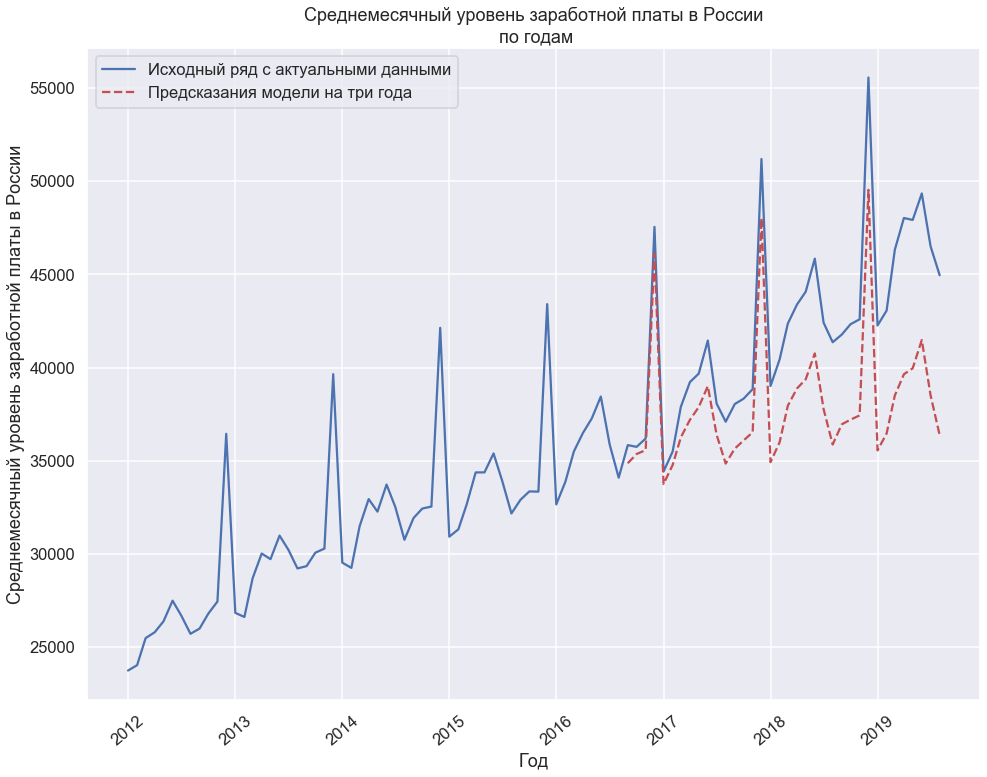

In [383]:
wage_forecast = wage[['WAG_C_M']]
last_date = datetime.utcfromtimestamp(wage_forecast.iloc[[-1]].index.values[0].tolist()/1e9)
date_list = [datetime.strptime(add_one_month(last_date)\
                               .strftime("%Y-%m-%d"), "%Y-%m-%d") +\
             relativedelta(months=x) for x in range(0, 36)]
future = pd.DataFrame(index=date_list, columns= wage_forecast.columns)
wage_forecast = pd.concat([wage_forecast, future])
wage_forecast['forecast'] = invboxcox(best_model.predict(start=wage.shape[0],
                                                         end=wage_forecast.shape[0]), 
                                      lmbda)

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 12))

wage_with_curr = pd.concat([wage, wage_curr], sort=False)

sns.lineplot(x=wage_with_curr.index[228:],
             y=wage_with_curr.WAG_C_M[228:], ax=ax)
sns.lineplot(x=wage_forecast.index, y=wage_forecast.forecast, ax=ax, color='r')
ax.lines[1].set_linestyle("--")
ax.set(xlabel="Год",
       ylabel="Cреднемесячный уровень заработной платы в России",
       title="Cреднемесячный уровень заработной платы в России\n по годам")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.xticks(rotation=40)
ax.legend(['Исходный ряд c актуальными данными', 
           'Предсказания модели на три года']);

Предсказания модели получились сильно заниженными. Для оценкой точности прогноза воспользуемся метрикой __SMAPE__:

$$SMAPE = \frac{100\%}{n}\sum_{t=1}^{n}{\frac{2\left\lvert F_t - A_t \right\rvert}{(\left\lvert A_t \right\rvert + \left\lvert F_t \right\rvert)}},$$

где:

- $A_t$ - Исходные данные
- $F_t$ - Предсказанные данные

In [384]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [403]:
print('Значение SMAPE = {:.2f}%'\
      .format(smape(wage_forecast.forecast.loc['2016-09-01':].values, 
                    wage_curr.WAG_C_M.values)))

Значение SMAPE = 9.96%


9.96% составляет ошибка $F_t$ от $A_t$

__Выводы:__ В данном ipython-ноутбуке были проанализированы данные о заработной плате за каждый месяц с января 1993 по август 2016, подобрана для них оптимальная прогнозирующая модель в классе ARIMA и построены прогнозы на каждый месяц на три года вперёд от конца данных с сравнением с актуальными данными по критерию SMAPE.